# DS5110 FNPJ
## Protocol illustration
### TCP:
TCP States:

SYN (Synchronization): Used to create a TCP connection

ACK (Acknowledgement): Used to acknowledge the reception of data or synchronization packets

PSH (Push): Instruct the network stacks to bypass buffering

URG (Urgent): Indicates out-of-band data that must be processed by the network stacks before
normal data

FIN (Finish): Gracefully terminate the TCP connection

RST (Reset): Immediately terminate the connection and drop any in-transit data
## DDoS type and detection

### TCP-based DDoS:
#### SYN Flood:

dur: < 0.1 sec (very short duration)  
state: match the regex:`^(S|S_[ASR]|S_RA|S_SA)$`  
tot_pkts/dur > normal baseline

#### ACK Flood:  
dur: > 10 sec (relatively long)  
tot_bytes: < 100 or (< baseline)  
state: match `^A+$|^[^APUFR]*A[^APUFR]*$`  

#### RST Attack:  
dur: < 0.1 or 0.05 sec (very short duration)  
state: `'^R|.*_R.*$'`  
tot_pkts/dur > normal baseline  

#### State Exhaustion Attack:  
dur: > 30 sec (relatively long)
tot_pkts: <= 3 (rare)   
state: `'^S[^A]*$|^S[^A]*_[^A]*$'`  

### UDP-based DDoS:
#### UDP Flood:  
Massive UDP small packets  
dur: < 0.1 sec  
tot_pkts/dur > normal baseline
tot_bytes: < 100 or (< baseline)  
src_bytes / tot_bytes: < 0.1 (close to 0)  

### ICMP-based DDoS:

#### ICMP Flood:  
Massive ICMP packets with high packet rate and uniform packet size  
dir: ->  
tot_pkts/dur > normal baseline (could be 1000)  
tot_bytes / dur < 200  
state: mainly ECO

#### Ping of Death:  
Extremely large paket  
dir: ->  
bytes_per_pkt > 2000 or  
tot_bytes: > 65535 bytes or  
tot_pkts>10 & bytes_per_pkt>1000  
state: ECO  

#### Smurf Attack:
A DDoS attack that floods a victim with ICMP echo replies by spoofing their IP address and broadcasting requests to a network.  
dir: <-  
bytes_per_pkt<200  
state: ECR  
search for an identical but opposite direction flow (same dur, tot_pkts, tot_bytes, state == ECO
and src_bytes == tot_bytes)

### HTTP-based DDoS:
#### HTTP Flood:  
 An attack that overwhelms a web server with a high volume of HTTP requests, exhausting its resources.  
tot_pkts/dur > normal baseline (could be 1000)  
tot_bytes < 100 (normal requests usually are 200 bytes+)  

#### Slowloris:  
A stealthy DDoS attack that opens multiple connections to a server and keeps them open as long as possible to exhaust resources.  
dur > 60 sec (usually < 10 sec)  
tot_pkts <= 3 (rare number)  
src_bytes < 100 (originator sent few contents)


#### RUDY Attack:  
An attack that submits long-form fields extremely slowly to crash or stall a web server.    
dur > 300 sec (extremely long connection)
src_bytes/dur < 1 (extremely low transmission speed)

### ARP-based DDoS:
#### ARP Flood:
A Layer 2 attack that overwhelms a network switch with fake ARP requests, causing a denial of service.  
tot_pkts/dur > 500 (usually 10)
tot_bytes $\approx$ 60  
state == 'REQ' or 'RSP'
  
#### ARP Spoofing:   
A man-in-the-middle attack where an attacker sends falsified ARP messages to link their MAC address with a legitimate IP address.   
Without IP and MAC, ARP Spoofing is hard to detect and lack accuracy and preciseness
tot_bytes > 70 or < 50 (usually 60)  
state == 'RSP'

### RTP/UDT-based DDoS:
#### Media Flow Flooding:  
A DDoS attack targeting media servers (e.g., VoIP, streaming) by flooding them with excessive traffic.  
Single direction, high packet rate, bandwidth occupation, and abnormal source flow
tot_pkts/dur > 5000 or baseline  
tot_bytes/dur > 100 mbps (1e8 bytes)  
src_bytes/tot_bytes < 0.1  
dir == '<-' or '->'  


"""

In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Tuple, Dict
from enum import Enum, auto
from re import compile
from datetime import datetime
from sklearn.metrics import classification_report, silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from google.colab import drive

# Data load and preprocessing here
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CY5210_FNPJ/1-Neris-20110810.binetflow.parquet'
df_primitive = pd.read_parquet(file_path)


Norm_reg = compile(r'(?i)\b(normal)\b')
Norm_Bckgnd_reg = compile(r'(?i)\b(background|normal)\b')


class TCPState(Enum):
    # An enum that represents the TCP states, auto() keep these states ordered
    START = auto()
    SYN_SENT = auto()
    SYN_ACKED = auto()
    ACKED = auto()
    RESET = auto()
    FINISHED = auto()

def is_abnormal_fsm(tcp_states: str) -> (bool, str):
    """
    Determine if a TCP state is abnormal.
    :param tcp_states: A string which the case doesn't matter that represents a TCP handshake
    :return: True if the state is abnormal, else False
    """
    current_state = TCPState.START
    for char in tcp_states.replace('_', ''):  # Remove delimiters
        if char == 'S':
            if current_state != TCPState.START:
                return True, f"Unexpected SYN in state {current_state}"
            current_state = TCPState.SYN_SENT
        elif char == 'A':
            if current_state == TCPState.SYN_SENT:
                current_state = TCPState.SYN_ACKED
            elif current_state == TCPState.SYN_ACKED:
                current_state = TCPState.ACKED
            else:
                return True, f"Unexpected ACK in state {current_state}"
        elif char == 'R':
            current_state = TCPState.RESET
            break  # RST terminates the flow
        elif char == 'F':
            current_state = TCPState.FINISHED
        else:
            return True, f"Invalid flag '{char}'"

    # Check if the final state is valid
    if current_state not in {TCPState.ACKED, TCPState.FINISHED, TCPState.RESET}:
        return True, f"Incomplete handshake (ended in {current_state})"
    return False, "Normal flow"


def preprocess(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe, add two columns for convenience, and prepare two dataframe for
    Normal flow only and Normal/Background flow only.
    :param df_: A DataFrame to be preprocessed
    :return: A preprocessed DataFrame added is_ddos and ddos_type columns
    """
    df_ = df_.iloc[:, :-1]
    # Rows containing NaN have to be gone
    for column in df_primitive.columns:
        df_primitive.drop(df_primitive[df_primitive[column].isin([np.nan])].index, inplace=True)

    df_['is_ddos'] = 0
    df_['ddos_type'] = 'normal'

    return df_

# Perform preprocessing and create baselines with normal netflow and possible needed
# normal/background netflow
df_primitive = preprocess(df_primitive)
df_norm = df_primitive[df_primitive['label'].str.contains(Norm_reg, regex=True, na=False)]
df_norm_bkgnd = df_primitive[df_primitive['label'].str.contains(Norm_Bckgnd_reg, regex=True, na=False)]
# print(df_norm.head(5), "\n", "=" * 50)
# print(df_norm_bkgnd.head(5))


def calculate_baseline(df_):
    df = df_.copy()
    df['pkts_per_sec'] = np.where(df['dur'] > 0,
                                  df['tot_pkts'] / df['dur'],
                                  np.nan)  # 将dur=0的速率设为NaN
    df['bytes_per_sec'] = np.where(df['dur'] > 0,
                                   df['tot_bytes'] / df['dur'],
                                   np.nan)
    df['src_bytes_per_sec'] = np.where(df['dur'] > 0,
                                       df['src_bytes'] / df['dur'],
                                       np.nan)

    # global statistics
    stats = {
        'global': {
            # basic metrics
            'dur_median': df['dur'].median(),
            'dur_q90': df['dur'].quantile(0.90),
            'tot_pkts_median': df['tot_pkts'].median(),
            'tot_bytes_q90': df['tot_bytes'].quantile(0.9),
            'src_bytes_median': df['src_bytes'].median(),

            # flow rate metrics
            'pkts_per_sec_median': df['pkts_per_sec'].median(skipna=True),
            'pkts_per_sec_q90': df['pkts_per_sec'].quantile(0.9, interpolation='higher'),
            'bytes_per_sec_median': df['bytes_per_sec'].median(skipna=True),
            'bytes_per_sec_q90': df['bytes_per_sec'].quantile(0.9, interpolation='higher'),
            'src_bytes_per_sec_median': df['src_bytes_per_sec'].median(skipna=True),
            'src_bytes_per_sec_q90': df['src_bytes_per_sec'].quantile(0.9, interpolation='higher')
        },

        # stat based on protocol
        'by_proto': df.groupby('proto').agg({
            # basic metrics
            'tot_pkts': [('median', 'median'),
                         ('q90', lambda x: x.quantile(0.9))],
            'tot_bytes': [('median', 'median'),
                          ('q90', lambda x: x.quantile(0.9))],
            'src_bytes': [('median', 'median'),
                          ('q90', lambda x: x.quantile(0.9))],
            'dur': [('median', 'median'),
                    ('count', 'count')],

            # flow/pkt rate metrics
            'pkts_per_sec': [('median', lambda x: x.median(skipna=True)),
                             ('q90', lambda x: x.quantile(0.9, interpolation='higher'))],
            'bytes_per_sec': [('median', lambda x: x.median(skipna=True)),
                              ('q90', lambda x: x.quantile(0.9, interpolation='higher'))],
            'src_bytes_per_sec': [('median', lambda x: x.median(skipna=True)),
                                  ('q90', lambda x: x.quantile(0.9, interpolation='higher'))]
        })
    }
    return stats

norm_baseline = calculate_baseline(df_norm)
norm_bkgnd_baseline = calculate_baseline(df_norm_bkgnd)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-3c8214fc0e23>:91: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_norm = df_primitive[df_primitive['label'].str.contains(Norm_reg, regex=True, na=False)]
<ipython-input-10-3c8214fc0e23>:92: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_norm_bkgnd = df_primitive[df_primitive['label'].str.contains(Norm_Bckgnd_reg, regex=True, na=False)]
<ipython-input-10-3c8214fc0e23>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'by_proto': df.groupby('proto').agg({
<ipython-input-10-3c8214fc0e23>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

In [11]:
# DDoS detection part
# print(norm_baseline)
print(norm_baseline['global'])
print(norm_baseline['by_proto'])
print(norm_baseline.keys())
print(norm_baseline['by_proto'].loc['tcp',('pkts_per_sec', 'median')])

global_dur_baseline = norm_baseline['global']['dur_median']
print(global_dur_baseline)


class DDoSDetector:
    def __init__(self, baseline: Dict, log_file: str = "ddos_detection.log"):
        """
        Initialize detector with baseline metrics and logging

        :param baseline: Pre-calculated baseline metrics dictionary
        :param log_file: Path to log file (default: ddos_detection.log)
        """
        self.baseline = baseline
        self._setup_logging(log_file)
        self._init_regex()
        self._load_baselines()

    def _setup_logging(self, log_file: str) -> None:
        """Configure logging system"""
        self.logger = logging.getLogger("DDoS_Detector")
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        self.logger.info("DDoS Detector initialized")

    def _init_regex(self) -> None:
        """Compile attack pattern regexes"""
        self.SYN_Flood = compile(r'^(S|S_[ASR]|S_RA|S_SA)$')
        self.ACK_Flood = compile(r'^A+$|^[^APUFR]*A[^APUFR]*$')
        self.RST_Attack = compile(r'^R|.*_R.*$')
        self.Exhaustion_Attack = compile(r'^S[^A]*$|^S[^A]*_[^A]*$')

    def _load_baselines(self) -> None:
        """Load protocol-specific baselines"""
        self.baselines = {
            'tcp': {
                'pkt_rate': self.baseline['by_proto'].loc['tcp', ('pkts_per_sec', 'median')],
                'byte_rate': self.baseline['by_proto'].loc['tcp', ('bytes_per_sec', 'median')]
            },
            'udp': {
                'pkt_rate': self.baseline['by_proto'].loc['udp', ('pkts_per_sec', 'median')],
                'byte_rate': self.baseline['by_proto'].loc['udp', ('bytes_per_sec', 'median')]
            },
            'icmp': {
                'pkt_rate': self.baseline['by_proto'].loc['icmp', ('pkts_per_sec', 'median')],
                'byte_rate': self.baseline['by_proto'].loc['icmp', ('bytes_per_sec', 'median')]
            },
            'media': {
                proto: self.baseline['by_proto'].loc[proto, ('pkts_per_sec', 'median')]
                for proto in ['udt', 'rtp']
            }
        }

    def detect(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Main detection function

        :param df: Input DataFrame with network flow data
        :return: DataFrame with detection results
        """
        if not {'proto', 'dur', 'tot_pkts', 'tot_bytes', 'state'}.issubset(df.columns):
            raise ValueError("Missing required columns in DataFrame")

        # Initialize result columns
        if 'is_ddos' not in df.columns:
            df['is_ddos'] = 0
        if 'ddos_type' not in df.columns:
            df['ddos_type'] = 'Normal'

        attack_counts = {}

        for idx, row in df.iterrows():
            try:
                proto = row['proto']
                result = (0, 'Normal')

                if proto == 'tcp':
                    result = self._detect_tcp(
                        row['dur'], row['tot_pkts'], row['tot_bytes'], row['state'])
                elif proto == 'udp':
                    result = self._detect_udp(
                        row['dur'], row['tot_pkts'], row['tot_bytes'], row['src_bytes'])
                elif proto == 'icmp':
                    result = self._detect_icmp(
                        row['dur'], row['dir'], row['tot_pkts'], row['tot_bytes'],
                        row['state'], df[df['proto'] == 'icmp'])
                elif proto == 'arp':
                    result = self._detect_arp(
                        row['dur'], row['tot_pkts'], row['tot_bytes'], row['state'])
                elif proto in ['udt', 'rtp']:
                    result = self._detect_media(
                        row['dur'], row['dir'], row['tot_pkts'], row['tot_bytes'],
                        row['src_bytes'])

                # Update results
                if result[0] != row['is_ddos'] or result[1] != row['ddos_type']:
                    df.at[idx, 'is_ddos'], df.at[idx, 'ddos_type'] = result
                    self.logger.info(
                        f"Row {idx} - {proto}: {row['state']} -> {result[1]}")

                    if result[0] == 1:
                        attack_counts[result[1]] = attack_counts.get(result[1], 0) + 1

            except Exception as e:
                self.logger.error(f"Row {idx} processing failed: {str(e)}")
                continue

        # Log summary
        self._log_summary(attack_counts, df)
        return df

    def _detect_tcp(self, dur: float, pkts: int, bytes_: int, state: str) -> Tuple[int, str]:
        """TCP attack detection logic"""
        rate = pkts / dur if dur > 0 else 0

        if dur < 0.1 and self.SYN_Flood.match(state) and rate > self.baselines['tcp']['pkt_rate']:
            return 1, "TCP SYN Flood"
        if (dur > 10 and self.ACK_Flood.search(state) and
                bytes_ < self.baselines['tcp']['byte_rate'] and
                rate > self.baselines['tcp']['pkt_rate']):
            return 1, "TCP ACK Flood"
        if dur < 0.1 and self.RST_Attack.match(state) and rate > self.baselines['tcp']['pkt_rate']:
            return 1, "TCP RST Flood"
        if dur > 30 and self.Exhaustion_Attack.match(state) and pkts <= 3:
            return 1, "TCP Exhaustion Attack"
        return 0, "Normal"

    def _detect_udp(self, dur: float, pkts: int, bytes_: int, src_bytes: int) -> Tuple[int, str]:
        """UDP attack detection logic"""
        if dur <= 0:
            return 0, "Normal"

        if (pkts/dur > self.baselines['udp']['pkt_rate'] and
                bytes_ < self.baselines['udp']['byte_rate'] and
                src_bytes/bytes_ < 0.1):
            return 1, "UDP Flood"
        return 0, "Normal"

    def _detect_icmp(self, dur: float, drctn: str, pkts: int, bytes_: int,
                     state: str, icmp_df: pd.DataFrame) -> Tuple[int, str]:
        """ICMP attack detection logic"""
        if dur <= 0 or pkts <= 0:
            return 0, "Normal"

        rate = pkts / dur
        byte_rate = bytes_ / dur
        bytes_per_pkt = bytes_ / pkts

        # ICMP symmetry check
        def _check_symmetry(dur_, pkts_, bytes__):
            eco_mask = (
                    (icmp_df['dur'] == dur_) &
                    (icmp_df['dir'] == '->') &
                    (icmp_df['tot_pkts'] == pkts_) &
                    (icmp_df['tot_bytes'] == bytes__) &
                    (icmp_df['state'] == "ECO") &
                    (icmp_df['src_bytes'] == bytes__)
            )
            ecr_mask = (
                    (icmp_df['dur'] == dur_) &
                    (icmp_df['dir'] == '<-') &
                    (icmp_df['tot_pkts'] == pkts_) &
                    (icmp_df['tot_bytes'] == bytes__) &
                    (icmp_df['state'] == "ECR") &
                    (icmp_df['src_bytes'] == 0)
            )
            return not icmp_df[eco_mask].empty and not icmp_df[ecr_mask].empty

        if (drctn == "->" and rate > self.baselines['icmp']['pkt_rate'] and
                byte_rate < 200 and state == "ECO"):
            return 1, "ICMP Flood"
        if (drctn == "->" and state == "ECO" and
                (bytes_per_pkt > 2000 or bytes_ > 65535 or (pkts > 10 and bytes_per_pkt > 1000))):
            return 1, "Ping of Death"
        if (drctn == "<-" and state == "ECR" and bytes_per_pkt < 200 and
                _check_symmetry(dur, pkts, bytes_)):
            return 1, "Smurf Attack"
        return 0, "Normal"

    def _detect_arp(self, dur: float, pkts: int, bytes_: int, state: str) -> Tuple[int, str]:
        """ARP attack detection logic"""
        if dur <= 0:
            return 0, "Normal"

        if pkts/dur > 500 and 55 <= bytes_ <= 65 and state in ('REQ', 'RSP'):
            return 1, "ARP Flood"
        return 0, "Normal"

    def _detect_media(self, dur: float, drctn: str, pkts: int, bytes_: int,
                      src_bytes: int) -> Tuple[int, str]:
        """UDT/RTP media flood detection"""
        if dur <= 0:
            return 0, "Normal"

        if (pkts/dur > 5000 and bytes_/dur > 1e8 and
                src_bytes/bytes_ < 0.1 and drctn in ('<-', '->')):
            return 1, "Media Flow Flood"
        return 0, "Normal"

    def _log_summary(self, attack_counts: Dict[str, int], df: pd.DataFrame) -> None:
        """Log detection summary statistics"""
        total = sum(attack_counts.values())
        self.logger.info("\n==== Detection Summary ====")
        self.logger.info(f"Total flows processed: {len(df)}")
        self.logger.info(f"Total attacks detected: {total}")

        for attack, count in attack_counts.items():
            self.logger.info(f"{attack}: {count} cases")


detector = DDoSDetector(norm_baseline, "network_security.log")
result_df = detector.detect(df_primitive)


{'dur_median': 0.0063795000314712524, 'dur_q90': np.float64(66.5772605895996), 'tot_pkts_median': 2.0, 'tot_bytes_q90': np.float64(5427.8000000000175), 'src_bytes_median': 81.0, 'pkts_per_sec_median': 750.2032582888328, 'pkts_per_sec_q90': np.float64(8298.755133293731), 'bytes_per_sec_median': 98217.18495195074, 'bytes_per_sec_q90': np.float64(1124087.6285926236), 'src_bytes_per_sec_median': 30511.093395889497, 'src_bytes_per_sec_q90': np.float64(321266.97591282654)}
          tot_pkts       tot_bytes          src_bytes                  dur  \
            median   q90    median      q90    median     q90       median   
proto                                                                        
arp            3.0   8.0     180.0    480.0      60.0   240.0  1800.366211   
esp            NaN   NaN       NaN      NaN       NaN     NaN          NaN   
icmp           1.0   1.8     137.0    795.4     137.0   795.4     0.000000   
igmp           NaN   NaN       NaN      NaN       NaN     Na

In [15]:
df_copy = df_primitive.copy()
df_copy = df_copy.sample(n=15000, random_state=42)  # Truncate total dataset


df_mapper = {
    'proto': {
        'arp':0, 'esp':1, 'icmp':2, 'igmp':3, 'ipv6':4, 'ipv6-icmp':5, 'ipx/spx':6, 'pim':7,
        'rarp':8, 'rtcp':9, 'rtp':10, 'tcp':11, 'udp':12, 'udt':13, 'unas':14
    },
    'ddos_type': {'Normal':0, 'TCP SYN Flood':1, 'TCP ACK Flood':2, 'TCP RST Flood':3,
                  'TCP Exhaustion Attack':4, 'UDP Flood':5, 'ICMP Flood':6, 'Ping of Death':7,
                  'Smurf Attack':8, 'ARP Flood':9, 'Media Flow Flood':10},
}

df_mapper_inv = df_mapper.copy()

# An inverse map for later mapping in clustering graph
for key in df_mapper_inv.keys():
  df_mapper_inv[key] = {v : k for k, v in df_mapper_inv[key].items()}

for col in df_mapper:
    if col in df_copy.columns:
        df_copy[col] = df_copy[col].map(df_mapper[col])

y_bin   = df_copy["is_ddos"]           # 0 / 1
y_multi = df_copy["ddos_type"]         # "Normal" or specific attack name
print(y_multi[:5])
X_raw       = df_copy.drop(columns=["state", "label", "is_ddos", "ddos_type"])


num_cols = X_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,      # keep it sparse if >30% zeros
)

X_scaled = preprocess.fit_transform(X_raw)

(
    X_tmp,
    X_test,
    y_tmp_bin,
    y_test_bin,
    y_tmp_multi,
    y_test_multi,
) = train_test_split(
    X_scaled,
    y_bin,
    y_multi,
    test_size=0.20,
    stratify=y_bin,
    random_state=42,
)

(
    X_train,
    X_val,
    y_train_bin,
    y_val_bin,
    y_train_multi,
    y_val_multi,
) = train_test_split(
    X_tmp,
    y_tmp_bin,
    y_tmp_multi,
    test_size=0.25,          # 0.25 × 0.80  ≈  0.20 of full set
    stratify=y_tmp_bin,
    random_state=42,
)

X_train = X_train[:5000]
y_train_bin = y_train_bin[:5000]
y_train_multi = y_train_multi[:5000]



1218782    0
119527     0
849396     0
1473414    0
461788     0
Name: ddos_type, dtype: int64



===  K‑MEANS (2 clusters) — Normal vs Attack  ===


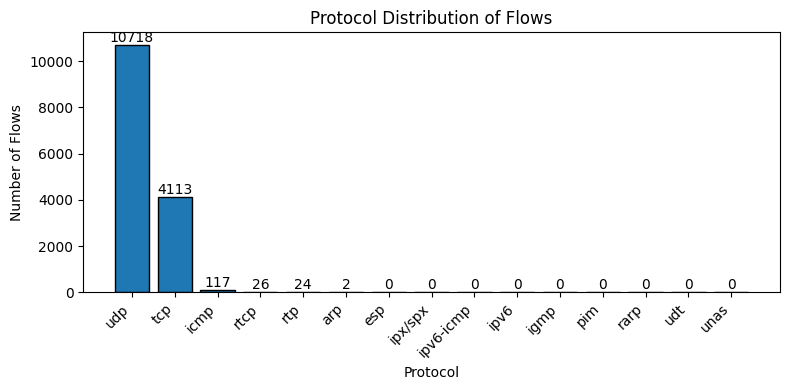

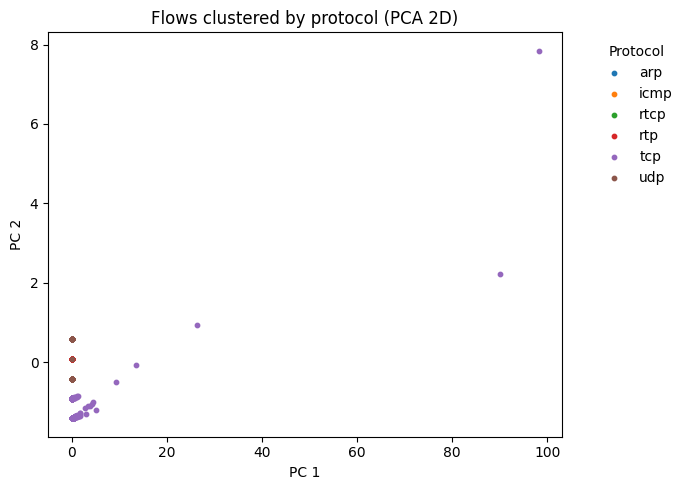

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.9973    1.0000    0.9987      2992
           1     0.0000    0.0000    0.0000         8

    accuracy                         0.9973      3000
   macro avg     0.4987    0.5000    0.4993      3000
weighted avg     0.9947    0.9973    0.9960      3000

Silhouette (train): 0.9925


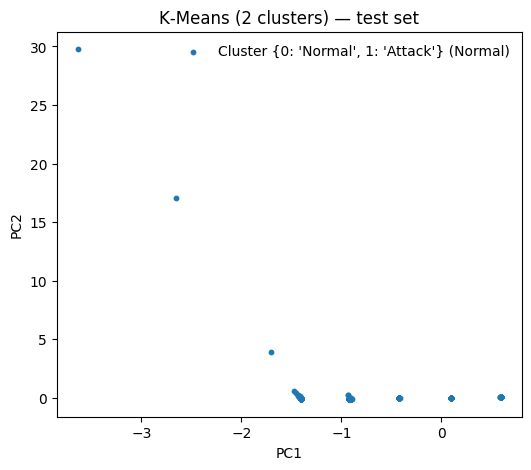


===  DBSCAN (Normal vs Attack)  ===
Silhouette (core points): 0.9907


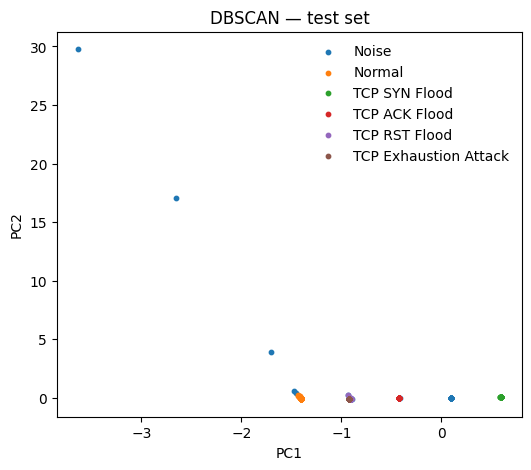

3

===  K‑MEANS (3 clusters) — within DDoS flows  ===
Adjusted Rand Index: 0.0786
cl:  0
Normal
cl:  1
TCP SYN Flood
cl:  2
TCP ACK Flood


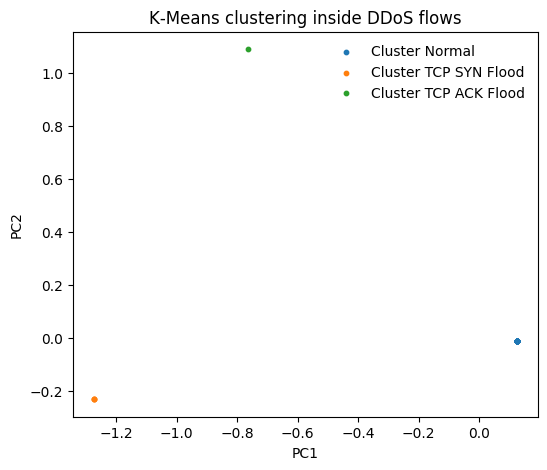

'\nplt.figure()\nplt.scatter(X_vis3[:, 0], X_vis3[:, 1], s=5, c=km_ddos.labels_)\nplt.title("K‑Means clustering inside DDoS flows")\nplt.xlabel("PC1"); plt.ylabel("PC2")\nplt.show()\n'

In [49]:
# Training
print("\n===  K‑MEANS (2 clusters) — Normal vs Attack  ===")
km_bin = KMeans(n_clusters=2, n_init=10, random_state=42)
km_bin.fit(X_train)

# Plotting the flows based on protocol types
X_vis_proto = PCA(n_components=2, random_state=42).fit_transform(
    X_scaled.toarray() if hasattr(X_scaled, "toarray") else X_scaled
)


protos = df_copy["proto"].values

proto_counts = df_copy["proto"].value_counts()

# print(proto_counts)
bar_x_axis = [df_mapper_inv['proto'][item] for item in list(proto_counts.index)]
# print(bar_x_axis)

# --Visulization-bar graph
plt.figure(figsize=(8,4))
bars = plt.bar(bar_x_axis, proto_counts.values, edgecolor="k")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center", va="bottom"
    )

plt.xlabel("Protocol")
plt.ylabel("Number of Flows")
plt.title("Protocol Distribution of Flows")
plt.xticks(rotation=45, ha="right")   # 斜着显示 x 轴标签，避免重叠
plt.tight_layout()
plt.show()

# --Visulization-scatter plot
plt.figure(figsize=(7,5))
unique_protos = np.unique(protos)
for p in unique_protos:
    # print("p: ", p)
    mask = (protos == p)
    plt.scatter(
        X_vis_proto[mask, 0],
        X_vis_proto[mask, 1],
        s=10,
        label=df_mapper_inv["proto"][p] if p in df_mapper_inv["proto"] else "Exception flow"
    )

plt.title("Flows clustered by protocol (PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Protocol", bbox_to_anchor=(1.05,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

# print(km_bin.labels_)

def majority_map(preds, true_labels):
    """Map each cluster id to the majority class it captured."""
    mapping = {}
    for cid in np.unique(preds):
        maj = true_labels[preds == cid].value_counts().idxmax()
        mapping[cid] = maj
    return mapping

cluster_map = majority_map(km_bin.labels_, y_train_bin.reset_index(drop=True))
val_preds   = [cluster_map[c] for c in km_bin.predict(X_val)]
print(classification_report(y_val_bin, val_preds, digits=4))
print("Silhouette (train):", silhouette_score(X_train, km_bin.labels_).round(4))

# ----- visualisation
pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(X_test)
test_clusters = km_bin.predict(X_test)
# print(test_clusters)

plt.figure(figsize=(6,5))
for cl in np.unique(test_clusters):
    # print("cl: ", cl)
    mask = test_clusters == cl
    # 用 cluster_map 映射成 “Normal” 或 “Attack”
    cl_translation = {0: "Normal", 1: "Attack"}
    name = f"Cluster {cl_translation} ({cl_translation[cluster_map[cl]]})"
    plt.scatter(X_vis[mask, 0], X_vis[mask, 1], s=10, label=name)
plt.title("K‑Means (2 clusters) — test set")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc="best", frameon=False)
plt.show()


"""
plt.figure()
plt.scatter(X_vis[:, 0], X_vis[:, 1], s=5, c=test_clusters)
plt.title("K‑Means (2 clusters) — test set")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
"""

# 3‑B.  Normal vs Attack  —  DBSCAN

print("\n===  DBSCAN (Normal vs Attack)  ===")
db = DBSCAN(eps=0.5, min_samples=10).fit(X_train)
core_mask = db.labels_ != -1
if core_mask.any():
    print("Silhouette (core points):",
          silhouette_score(X_train[core_mask], db.labels_[core_mask]).round(4))
else:
    print("All points marked noise — adjust eps/min_samples!")

# ----- visualisation
db_test = DBSCAN(eps=0.5, min_samples=10).fit(X_test)
labels_db = db_test.labels_
X_vis2 = PCA(n_components=2, random_state=42).fit_transform(X_test)

plt.figure(figsize=(6,5))
for lbl in np.unique(labels_db):
    # print("lbl: ", lbl)
    mask = labels_db == lbl
    name = "Noise" if lbl == -1 else df_mapper_inv["ddos_type"][int(lbl)]
    plt.scatter(X_vis2[mask, 0], X_vis2[mask, 1], s=10, label=name)
plt.title("DBSCAN — test set")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc="best", frameon=False)
plt.show()

"""
plt.figure()
plt.scatter(X_vis2[:, 0], X_vis2[:, 1], s=5, c=db_test.labels_)
plt.title("DBSCAN — test set")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
"""

# 4.  Cluster  DDoS  flows by attack type
# print("y_bin: \n", y_bin)
# y_bin marks if this is a ddos
ddos_mask   = y_bin == 1
# print(ddos_mask)
# print(y_multi) numeric value now
# print("X_scaled: \n", X_scaled) Numeric cols processed by PCA
X_ddos      = X_scaled[ddos_mask]
y_ddos      = y_multi[ddos_mask]
# print(X_ddos[:50])
# print(y_ddos[:50]) match to actual attack type
n_types     = y_ddos.nunique()
print(n_types)

print(f"\n===  K‑MEANS ({n_types} clusters) — within DDoS flows  ===")
km_ddos = KMeans(n_clusters=n_types, n_init=20, random_state=42).fit(X_ddos)
#print("Adjusted Rand Index:", adjusted_rand_score(y_ddos, km_ddos.labels_).round(4))
print("Adjusted Rand Index:", np.nan_to_num(adjusted_rand_score(y_ddos, km_ddos.labels_)).round(4))

# ----- visualisation
X_vis3 = pca.fit_transform(X_ddos.toarray() if hasattr(X_ddos, "toarray") else X_ddos)

plt.figure(figsize=(6,5))
for cl in np.unique(km_ddos.labels_):
    print("cl: ", cl)
    mask = km_ddos.labels_ == cl
    label_name = df_mapper_inv["ddos_type"][int(cl)]
    print(label_name)
    plt.scatter(X_vis3[mask, 0], X_vis3[mask, 1], s=10, label=f"Cluster {label_name}")
plt.title("K‑Means clustering inside DDoS flows")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc="best", frameon=False)
plt.show()

"""
plt.figure()
plt.scatter(X_vis3[:, 0], X_vis3[:, 1], s=5, c=km_ddos.labels_)
plt.title("K‑Means clustering inside DDoS flows")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
"""


===  Surrogate GB classifier for SHAP explanations  ===
Surrogate accuracy (val): 1.0


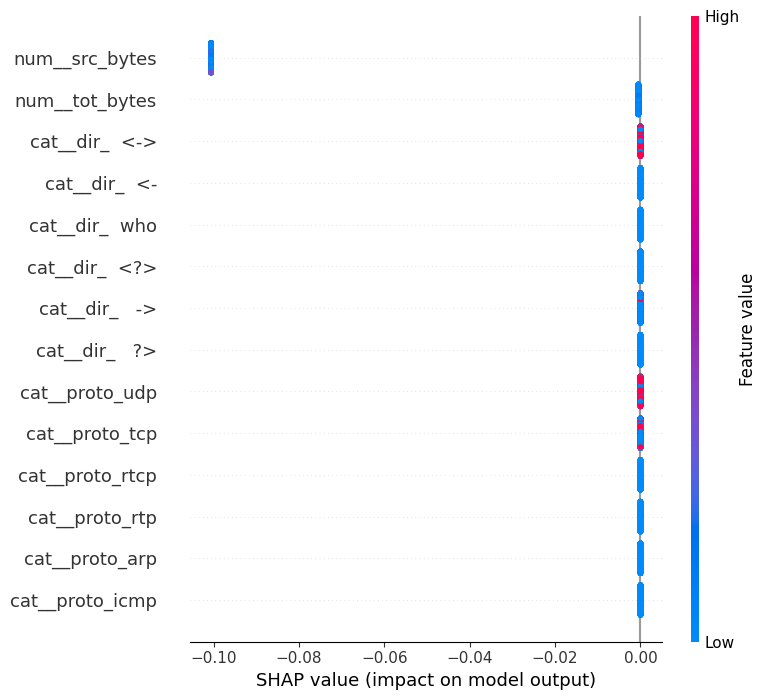

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import shap

print("\n===  Surrogate GB classifier for SHAP explanations  ===")
y_train_sur  = km_bin.predict(X_train)
y_val_sur    = km_bin.predict(X_val)

# GradientBoostingClassifier is the surrogate model
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train_sur)

#print("Surrogate accuracy (val):", gb.score(X_val, y_val_sur).round(4))
print("Surrogate accuracy (val):", round(gb.score(X_val, y_val_sur), 4))

explainer = shap.TreeExplainer(
    gb,
    feature_names=preprocess.get_feature_names_out(),
    feature_perturbation="tree_path_dependent",
)
# smaller background sample for speed
# Convert the sparse matrices to dense arrays
sample = shap.utils.sample(X_val, 2000, random_state=1).toarray()
shap_values = explainer.shap_values(sample, check_additivity=False)

#── global explanation
shap.summary_plot(
    shap_values,
    sample,
    feature_names=preprocess.get_feature_names_out(),
    show=True,
)

#── local explanation (pick any row)
idx = 0
shap.initjs()
# Convert X_val[idx] to a dense array
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_val[idx].toarray())[0],
    features=X_val[idx].toarray(),
    feature_names=preprocess.get_feature_names_out(),
    show=False
)
plt.show()